In [1]:
# Core libraries
import scanpy as sc

# Try to use GPU-accelerated rapids_singlecell, fall back to scanpy
try:
    import rapids_singlecell as rsc
    import cupy as cp
    import rmm
    from rmm.allocators.cupy import rmm_cupy_allocator
    USE_GPU = True
    print("Using GPU-accelerated rapids_singlecell")
except ImportError:
    rsc = sc
    USE_GPU = False
    print("rapids_singlecell not available, using scanpy (CPU)")

# Data manipulation
import numpy as np
import pandas as pd
from collections import defaultdict

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

import os
import yaml

Using GPU-accelerated rapids_singlecell


/home/ncostigan/.local/share/mamba/envs/prisma/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Initialize GPU memory management (only if using rapids)
if USE_GPU:
    rmm.reinitialize(
        managed_memory=False,
        pool_allocator=True,
        devices=0,
    )
    cp.cuda.set_allocator(rmm_cupy_allocator)

In [3]:
# =============================================================================
# CONFIGURATION - Load from config file
# =============================================================================

CONFIG_PATH = "config/annotate.yaml"

with open(CONFIG_PATH, 'r') as f:
    config = yaml.safe_load(f)

# Extract config values
INPUT_FILE = config['input_file']
OUTPUT_DIR = config['output_dir']
OUTPUT_PREFIX = config['output_prefix']

# Load panels dynamically - each key becomes an annotation type
# e.g., "cell_type_markers" -> annotation name "cell_type"
PANELS = {}
for panel_key, panel_path in config['panels'].items():
    # Derive annotation name by removing "_markers" suffix
    annotation_name = panel_key.replace('_markers', '')
    PANELS[annotation_name] = panel_path

# Annotation parameters
MIN_SCORE = config.get('min_score', None)

print(f"Loaded config from {CONFIG_PATH}")
print(f"Input: {INPUT_FILE}")
print(f"Output prefix: {OUTPUT_PREFIX}")
print(f"Min score threshold: {MIN_SCORE}")
print(f"Panels: {list(PANELS.keys())}")

Loaded config from config/annotate.yaml
Input: tma_processed.h5ad
Output prefix: tma
Min score threshold: 0.1
Panels: ['cell_type', 'cell_state', 'gbm_subtype']


In [4]:
# Set up output directories
sc.settings.figdir = os.path.join(OUTPUT_DIR, 'plots/annotate')
os.makedirs(sc.settings.figdir, exist_ok=True)

In [5]:
# Load preprocessed data
adata = sc.read_h5ad(INPUT_FILE)
print(f"Loaded: {adata.shape[0]} cells x {adata.shape[1]} genes")
print(f"Clusters: {adata.obs['leiden'].nunique()} unique values")
print(f"\nCluster sizes:")
print(adata.obs['leiden'].value_counts())

Loaded: 383738 cells x 443 genes
Clusters: 18 unique values

Cluster sizes:
leiden
14    51523
9     35064
8     34405
16    32872
10    26206
15    21153
17    21007
12    20719
4     17856
11    17677
1     17025
13    16643
0     15803
3     14060
2     13856
5     13385
7      9619
6      4865
Name: count, dtype: int64


In [6]:
# Load all marker panels dynamically
available_genes = set(adata.var_names)

def parse_panel(panel_path, annotation_name, available_genes):
    """Parse panel CSV into category -> gene list dictionary."""
    panel_df = pd.read_csv(panel_path)
    
    # Find the category column (should match annotation_name or be second column)
    if annotation_name in panel_df.columns:
        category_col = annotation_name
    else:
        # Use second column (first is 'gene')
        category_col = panel_df.columns[1]
    
    category_to_genes = defaultdict(list)
    for _, row in panel_df.iterrows():
        gene = row['gene']
        category = row[category_col]
        if gene in available_genes:
            category_to_genes[category].append(gene)
    
    return dict(category_to_genes)

# Load all panels
panel_data = {}  # annotation_name -> {category -> [genes]}
for annotation_name, panel_path in PANELS.items():
    panel_data[annotation_name] = parse_panel(panel_path, annotation_name, available_genes)
    n_categories = len(panel_data[annotation_name])
    n_genes = sum(len(genes) for genes in panel_data[annotation_name].values())
    print(f"{annotation_name}: {n_categories} categories, {n_genes} genes in data")
    print(f"  Categories: {list(panel_data[annotation_name].keys())}")

cell_type: 14 categories, 73 genes in data
  Categories: ['Excitatory Neurons', 'OPCs', 'Oligodendrocytes', 'Astrocytes', 'Vascular Cells', 'Neural Stem Cells', 'Microglia', 'CD8+ T Cells', 'CD4+ T Cells', 'Regulatory T Cells ', 'Exhausted T Cells ', 'Tumor-Associated Macrophages', 'Glioblastoma (Cancer cells)', 'Glioblastoma (TME)']
cell_state: 4 categories, 18 genes in data
  Categories: ['Proliferation', 'Migration', 'Angiogenesis', 'Hypoxia']
gbm_subtype: 7 categories, 34 genes in data
  Categories: ['AC', 'G2/M', 'MES1', 'MES2', 'NPC1', 'NPC2', 'OPC']


In [7]:
def run_score_genes(adata, gene_list, score_name,  use_gpu=True):
    """
    Run score_genes using either rapids_singlecell (GPU) or scanpy (CPU).
    """
    # Filter to genes present in data
    valid_genes = [g for g in gene_list if g in adata.var_names]
    
    if len(valid_genes) == 0:
        print(f"  Warning: No valid genes for {score_name}")
        adata.obs[score_name] = 0.0
        return
    
    if use_gpu and USE_GPU:
        rsc.tl.score_genes(adata, valid_genes, score_name=score_name)
    else:
        sc.tl.score_genes(adata, valid_genes, score_name=score_name)

In [8]:
# Prepare data for scoring
# score_genes expects log-normalized data, use counts layer if available
adata_score = adata.copy()

if USE_GPU:
    rsc.get.anndata_to_GPU(adata_score)

In [9]:
# Score all panels
for annotation_name, category_to_genes in panel_data.items():
    print(f"Scoring {annotation_name}...")
    for category, genes in category_to_genes.items():
        score_name = f"score_{annotation_name}_{category.replace(' ', '_').replace('/', '_')}"
        run_score_genes(adata_score, genes, score_name, use_gpu=USE_GPU)
        print(f"  {category}: {len(genes)} genes")

Scoring cell_type...
  Excitatory Neurons: 1 genes
  OPCs: 2 genes
  Oligodendrocytes: 1 genes
  Astrocytes: 3 genes
  Vascular Cells: 3 genes
  Neural Stem Cells: 2 genes
  Microglia: 13 genes
  CD8+ T Cells: 6 genes
  CD4+ T Cells: 1 genes
  Regulatory T Cells : 3 genes
  Exhausted T Cells : 5 genes
  Tumor-Associated Macrophages: 7 genes
  Glioblastoma (Cancer cells): 4 genes
  Glioblastoma (TME): 22 genes
Scoring cell_state...
  Proliferation: 5 genes
  Migration: 6 genes
  Angiogenesis: 5 genes
  Hypoxia: 2 genes
Scoring gbm_subtype...
  AC: 6 genes
  G2/M: 2 genes
  MES1: 12 genes
  MES2: 2 genes
  NPC1: 5 genes
  NPC2: 3 genes
  OPC: 4 genes


In [10]:
def aggregate_cluster_scores(adata, category_to_genes, annotation_name):
    """
    Aggregate per-cell scores to per-cluster mean scores.
    Returns a DataFrame with clusters as rows and categories as columns.
    """
    clusters = sorted(adata.obs['leiden'].unique(), key=lambda x: int(x) if str(x).isdigit() else x)
    
    results = {}
    for cluster in clusters:
        mask = adata.obs['leiden'] == cluster
        results[cluster] = {}
        
        for cat in category_to_genes.keys():
            cat_safe = cat.replace(' ', '_').replace('/', '_')
            col = f"score_{annotation_name}_{cat_safe}"
            if col in adata.obs.columns:
                values = adata.obs.loc[mask, col]
                results[cluster][cat] = np.mean(values)
    
    return pd.DataFrame(results).T

In [11]:
# Aggregate scores per cluster for all panels
scores_data = {}  # annotation_name -> DataFrame of scores
for annotation_name, category_to_genes in panel_data.items():
    scores_data[annotation_name] = aggregate_cluster_scores(adata_score, category_to_genes, annotation_name)
    print(f"\n{annotation_name} scores per cluster:")
    display(scores_data[annotation_name])


cell_type scores per cluster:


,Excitatory Neurons,OPCs,Oligodendrocytes,Astrocytes,Vascular Cells,Neural Stem Cells,Microglia,CD8+ T Cells,CD4+ T Cells,Regulatory T Cells,Exhausted T Cells,Tumor-Associated Macrophages,Glioblastoma (Cancer cells),Glioblastoma (TME)
0,-0.375602,-0.142418,-0.245881,-0.932287,1.865879,-0.088355,0.021954,0.036032,0.288995,-0.003312,-0.005396,0.062789,-0.005780,-0.075423
1,-0.043122,0.052912,0.066849,0.138783,-0.303444,-0.062010,0.136082,-0.022357,0.200241,0.010450,-0.029958,0.058872,-0.093984,0.108351
2,0.765301,-0.057220,0.417560,-0.197479,-0.234866,-0.206199,-0.220397,0.038553,-0.229747,-0.074762,-0.021386,-0.181921,-0.219754,-0.120319
3,-0.395857,-0.470065,-0.242934,-1.309485,2.185739,0.715679,-0.056411,-0.008712,-0.208869,-0.018911,0.063965,-0.038224,-0.065478,-0.148355
4,0.008198,-0.275566,-0.110548,-0.381306,-0.063739,-0.333366,0.238544,-0.013621,0.269751,0.002435,-0.028451,0.190709,-0.114724,0.194496
5,-0.050446,0.164549,-0.067552,0.189228,-0.090478,0.027669,-0.163416,-0.001848,-0.222665,-0.005443,-0.000134,-0.079236,0.003946,-0.099611
6,-0.006679,-0.311638,-0.083357,-0.772119,0.192949,-0.188416,0.070282,1.186338,0.444970,-0.135416,0.093265,-0.039378,-0.099178,0.681461
7,0.489864,-0.101275,0.449696,-0.048717,-0.036432,-0.147399,-0.106242,0.015250,-0.076115,-0.024223,0.012634,-0.066086,-0.120563,-0.031049
8,-0.040123,-0.025542,-0.122343,0.150409,-0.258792,0.116946,-0.142101,-0.028012,-0.373863,0.000356,-0.020202,-0.121054,0.357375,-0.146780
9,-0.004181,-0.012193,-0.007917,-0.045711,-0.018296,-0.033775,-0.054227,-0.002326,-0.093742,-0.003321,-0.007309,-0.014661,0.223065,-0.023706



cell_state scores per cluster:


,Proliferation,Migration,Angiogenesis,Hypoxia
0,-0.167100,-0.006096,0.023007,0.020948
1,-0.006506,-0.010771,-0.112505,-0.139566
2,-0.020724,-0.041635,-0.050348,-0.134226
3,0.025258,-0.108767,0.522481,0.146107
4,-0.103932,0.083883,-0.081517,0.049284
5,1.035885,-0.092278,-0.042751,-0.016580
6,0.029848,-0.150540,-0.183195,0.529808
7,-0.009980,-0.006369,-0.009462,-0.045226
8,-0.206431,0.000078,0.060436,0.000076
9,-0.056425,0.013125,0.126903,0.052989



gbm_subtype scores per cluster:


,AC,G2/M,MES1,MES2,NPC1,NPC2,OPC
0,-0.450965,-0.121589,0.463797,0.097668,-0.354363,-0.183411,-0.450531
1,0.067572,-0.088454,-0.028210,-0.082679,0.106265,0.068158,0.098341
2,-0.216979,0.000289,-0.238972,-0.012390,0.261978,0.350218,-0.106970
3,-0.566190,-0.266576,0.193301,0.839405,-0.415016,-0.169871,-0.624952
4,-0.325491,-0.101408,0.029161,0.013194,-0.211892,-0.154154,-0.333429
5,0.036521,1.489442,-0.177664,-0.016704,0.361604,0.482623,0.067174
6,-0.649135,0.039798,-0.119578,-0.091339,-0.342195,-0.257954,-0.557354
7,-0.045213,-0.012262,-0.164598,-0.029289,0.228192,0.354567,-0.061026
8,0.059933,-0.265371,0.394288,0.049035,-0.262585,-0.241940,-0.059461
9,-0.087036,-0.049442,0.102114,0.231008,-0.146857,-0.080589,-0.176395


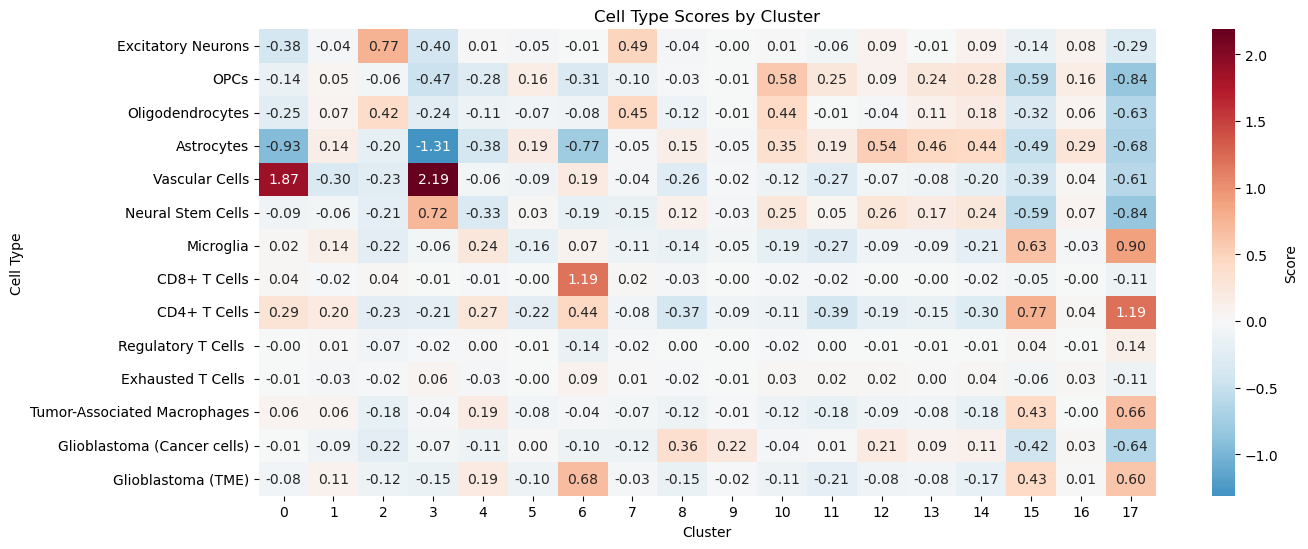

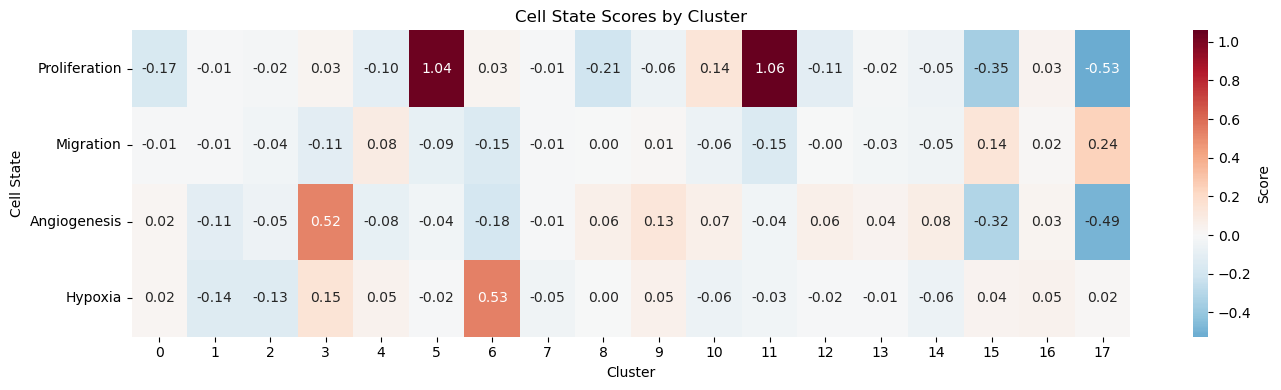

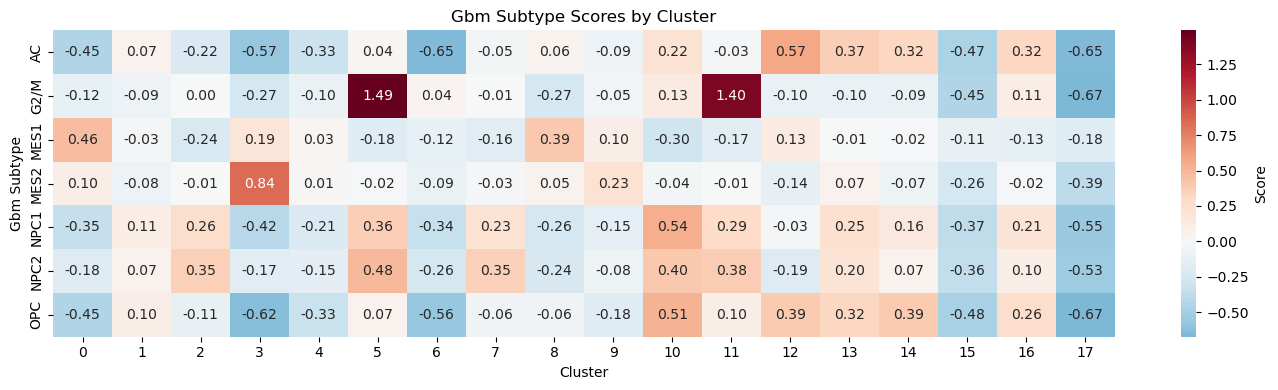

In [12]:
# Generate heatmaps for all panels
for annotation_name, scores_df in scores_data.items():
    n_categories = len(scores_df.columns)
    fig_height = max(4, n_categories * 0.4)
    
    fig, ax = plt.subplots(figsize=(14, fig_height))
    sns.heatmap(scores_df.T, cmap='RdBu_r', center=0, ax=ax,
                annot=True, fmt='.2f', cbar_kws={'label': 'Score'})
    ax.set_xlabel('Cluster')
    ax.set_ylabel(annotation_name.replace('_', ' ').title())
    ax.set_title(f'{annotation_name.replace("_", " ").title()} Scores by Cluster')
    plt.tight_layout()
    plt.savefig(f'{sc.settings.figdir}/{OUTPUT_PREFIX}_{annotation_name}_scores.png', dpi=150, bbox_inches='tight')
    plt.show()

In [13]:
def assign_annotation(scores_df, min_score=None, default='Unclassified'):
    """
    Assign annotation to each cluster based on highest score.
    Returns dict with cluster -> {primary, score, second, second_score, third, third_score}
    If min_score is set and highest score is below it, primary will be 'Unclassified'.
    """
    assignments = {}
    
    for cluster in scores_df.index:
        row = scores_df.loc[cluster]
        sorted_scores = row.sort_values(ascending=False)
        
        primary = sorted_scores.index[0]
        primary_score = sorted_scores.iloc[0]
        
        # Apply minimum score threshold
        if min_score is not None and primary_score < min_score:
            primary = default
        
        second = sorted_scores.index[1] if len(sorted_scores) > 1 else default
        second_score = sorted_scores.iloc[1] if len(sorted_scores) > 1 else 0
        
        third = sorted_scores.index[2] if len(sorted_scores) > 2 else default
        third_score = sorted_scores.iloc[2] if len(sorted_scores) > 2 else 0
        
        assignments[cluster] = {
            'primary': primary,
            'score': primary_score,
            'second': second,
            'second_score': second_score,
            'third': third,
            'third_score': third_score
        }
    
    return assignments

In [14]:
# Assign annotations for all panels
assignments_data = {}  # annotation_name -> {cluster -> assignment_dict}
for annotation_name, scores_df in scores_data.items():
    assignments_data[annotation_name] = assign_annotation(scores_df, min_score=MIN_SCORE)


def get_top_genes_for_category(adata, cluster, genes, n_top=3):
    """Get top expressing genes from a specific gene list for a cluster."""
    valid_genes = [g for g in genes if g in adata.var_names]
    if not valid_genes:
        return ""
    
    mask = adata.obs['leiden'] == cluster
    cluster_data = adata[mask, valid_genes]
    
    if hasattr(cluster_data.X, 'toarray'):
        mean_expr = np.array(cluster_data.X.toarray().mean(axis=0)).flatten()
    else:
        mean_expr = np.array(cluster_data.X.mean(axis=0)).flatten()
    
    top_indices = np.argsort(mean_expr)[::-1][:n_top]
    top_genes = [valid_genes[i] for i in top_indices]
    return ", ".join(top_genes)


# Create summary table with all annotations
summary_data = []
clusters = sorted(scores_data[list(scores_data.keys())[0]].index, key=lambda x: int(x) if str(x).isdigit() else x)

for cluster in clusters:
    n_cells = (adata.obs['leiden'] == cluster).sum()
    row = {'Cluster': cluster, 'N_Cells': n_cells}
    
    # Add columns for each annotation type
    for annotation_name in assignments_data.keys():
        a = assignments_data[annotation_name][cluster]
        category_to_genes = panel_data[annotation_name]
        
        # Primary annotation
        row[annotation_name] = a['primary']
        row[f'{annotation_name}_score'] = f"{a['score']:.3f}"
        # Top genes for primary
        if a['primary'] in category_to_genes:
            row[f'{annotation_name}_genes'] = get_top_genes_for_category(adata, cluster, category_to_genes[a['primary']])
        else:
            row[f'{annotation_name}_genes'] = ""
        
        # 2nd annotation
        row[f'{annotation_name}_2nd'] = a['second']
        row[f'{annotation_name}_2nd_score'] = f"{a['second_score']:.3f}"
        if a['second'] in category_to_genes:
            row[f'{annotation_name}_2nd_genes'] = get_top_genes_for_category(adata, cluster, category_to_genes[a['second']])
        else:
            row[f'{annotation_name}_2nd_genes'] = ""
        
        # 3rd annotation
        row[f'{annotation_name}_3rd'] = a['third']
        row[f'{annotation_name}_3rd_score'] = f"{a['third_score']:.3f}"
        if a['third'] in category_to_genes:
            row[f'{annotation_name}_3rd_genes'] = get_top_genes_for_category(adata, cluster, category_to_genes[a['third']])
        else:
            row[f'{annotation_name}_3rd_genes'] = ""
    
    summary_data.append(row)

summary_df = pd.DataFrame(summary_data)
print("Cluster Annotations Summary:")
display(summary_df)

Cluster Annotations Summary:


,Cluster,N_Cells,cell_type,cell_type_score,cell_type_genes,cell_type_2nd,cell_type_2nd_score,cell_type_2nd_genes,cell_type_3rd,cell_type_3rd_score,...,cell_state_3rd_genes,gbm_subtype,gbm_subtype_score,gbm_subtype_genes,gbm_subtype_2nd,gbm_subtype_2nd_score,gbm_subtype_2nd_genes,gbm_subtype_3rd,gbm_subtype_3rd_score,gbm_subtype_3rd_genes
0,0,15803,Vascular Cells,1.866,"DCN, RGS5, FLT1",CD4+ T Cells,0.289,CD4,Tumor-Associated Macrophages,0.063,...,"MMP9, MMP12, CTSS",MES1,0.464,"FN1, MGP, IGFBP7",MES2,0.098,"IGFBP3, CDKN1A",G2/M,-0.122,"PLK1, CENPF"
1,1,17025,CD4+ T Cells,0.200,CD4,Astrocytes,0.139,"S100B, SOX9, SLC1A3",Microglia,0.136,...,"FGF2, VEGFA, CXCL2",NPC1,0.106,"BCAN, SOX11, STMN1",OPC,0.098,"BCAN, VCAN, TTYH1",NPC2,0.068,"SOX11, STMN1, SOX4"
2,2,13856,Excitatory Neurons,0.765,NELL2,Oligodendrocytes,0.418,ERBB3,CD8+ T Cells,0.039,...,"VEGFA, FGF2, CXCL1",NPC2,0.350,"STMN1, SOX4, SOX11",NPC1,0.262,"STMN1, DLL3, SOX4",G2/M,0.000,"PLK1, CENPF"
3,3,14060,Vascular Cells,2.186,"FLT1, RGS5, DCN",Neural Stem Cells,0.716,"ID1, NOTCH1",Exhausted T Cells,0.064,...,"KIT, CDK1, MKI67",MES2,0.839,"IGFBP3, CDKN1A",MES1,0.193,"FN1, A2M, IGFBP7",NPC2,-0.170,"SOX4, STMN1, SOX11"
4,4,17856,CD4+ T Cells,0.270,CD4,Microglia,0.239,"AIF1, TREM2, CX3CR1",Glioblastoma (TME),0.194,...,"CXCL2, CXCL1, FLT1",Unclassified,0.029,,MES2,0.013,"IGFBP3, CDKN1A",G2/M,-0.101,"PLK1, CENPF"
5,5,13385,Astrocytes,0.189,"S100B, SOX9, SLC1A3",OPCs,0.165,"PDGFRA, VCAN",Neural Stem Cells,0.028,...,"CXCL2, CXCL1, VEGFA",G2/M,1.489,"CENPF, PLK1",NPC2,0.483,"STMN1, SOX11, SOX4",NPC1,0.362,"STMN1, SOX11, BCAN"
6,6,4865,CD8+ T Cells,1.186,"GZMA, GZMK, CD8A",Glioblastoma (TME),0.681,"CD2, IL7R, GZMA",CD4+ T Cells,0.445,...,"CTSS, MMP12, MMP9",Unclassified,0.040,,MES2,-0.091,"IGFBP3, CDKN1A",MES1,-0.120,"MGP, IFITM3, FN1"
7,7,9619,Excitatory Neurons,0.490,NELL2,Oligodendrocytes,0.450,ERBB3,CD8+ T Cells,0.015,...,"KIT, CDK6, CDK1",NPC2,0.355,"STMN1, SOX4, SOX11",NPC1,0.228,"STMN1, DLL3, SOX4",G2/M,-0.012,"PLK1, CENPF"
8,8,34405,Glioblastoma (Cancer cells),0.357,"CD44, ANXA1, CAV1",Astrocytes,0.150,"SOX9, SLC1A3, S100B",Neural Stem Cells,0.117,...,"HIF1A, CXCR4",MES1,0.394,"CD44, C1R, C1S",AC,0.060,"SPARCL1, SLC1A3, TTYH1",MES2,0.049,"CDKN1A, IGFBP3"
9,9,35064,Glioblastoma (Cancer cells),0.223,"CD44, CAV1, ANXA1",CD8+ T Cells,-0.002,"GZMB, CD8B, GZMK",Regulatory T Cells,-0.003,...,"MMP12, MMP9, CTSL",MES2,0.231,"IGFBP3, CDKN1A",MES1,0.102,"CD44, SPP1, ANXA1",G2/M,-0.049,"PLK1, CENPF"


In [15]:
# Apply all annotations to adata
leiden_str = adata.obs['leiden'].astype(str)

for annotation_name, assignments in assignments_data.items():
    cluster_to_annotation = {str(c): assignments[c]['primary'] for c in assignments}
    adata.obs[annotation_name] = leiden_str.map(cluster_to_annotation).astype('category')
    print(f"Added {annotation_name} annotation")

# Copy scores to original adata
score_cols = [c for c in adata_score.obs.columns if c.startswith('score_')]
for col in score_cols:
    adata.obs[col] = adata_score.obs[col]

print(f"Added {len(score_cols)} score columns")

Added cell_type annotation
Added cell_state annotation
Added gbm_subtype annotation
Added 25 score columns


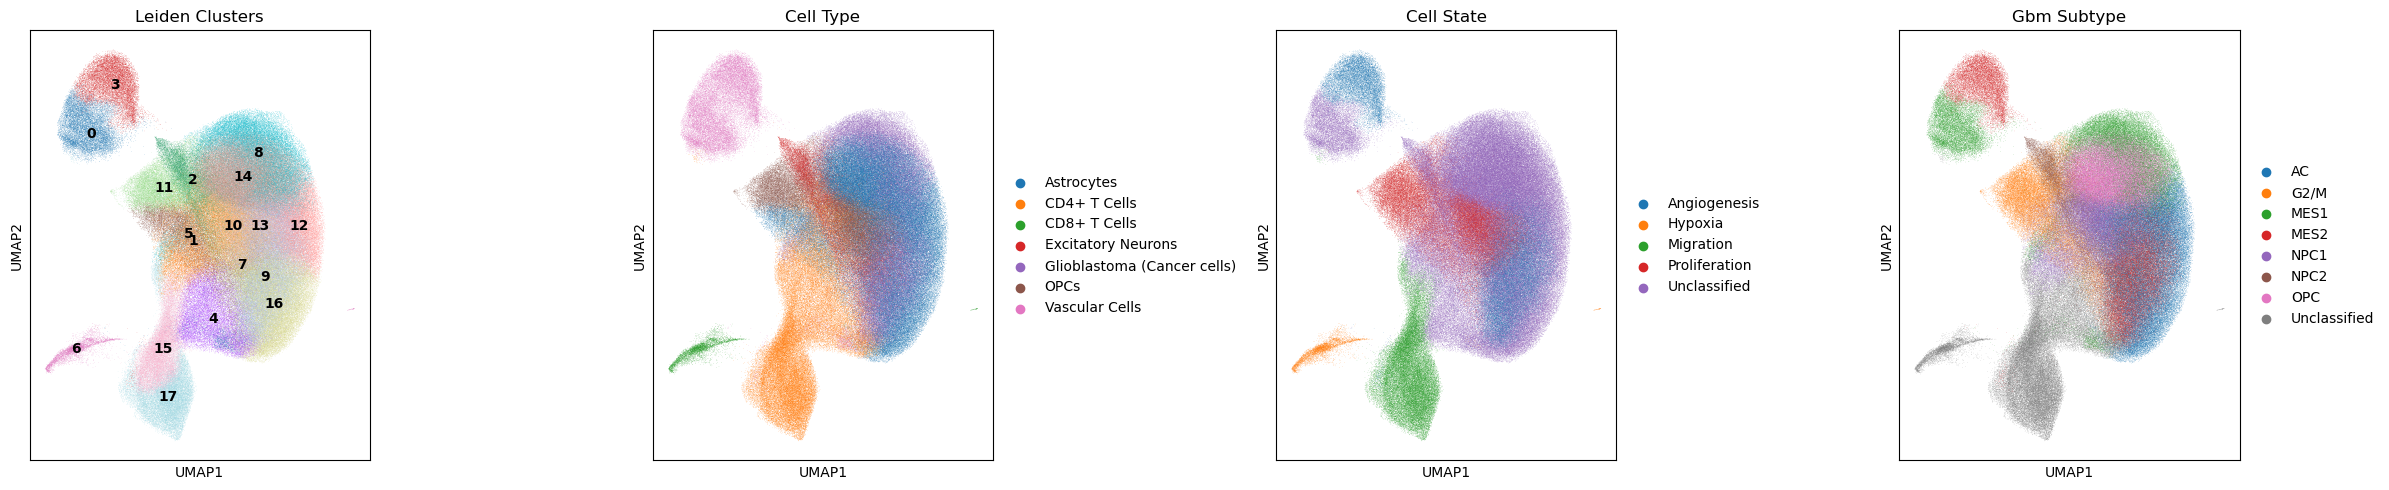

In [16]:
# Visualize on UMAP - leiden plus all annotation types
n_plots = 1 + len(assignments_data)  # leiden + each annotation
fig, axes = plt.subplots(1, n_plots, figsize=(6 * n_plots, 5))

sc.pl.umap(adata, color='leiden', ax=axes[0], show=False, title='Leiden Clusters', legend_loc='on data')

for idx, annotation_name in enumerate(assignments_data.keys(), start=1):
    sc.pl.umap(adata, color=annotation_name, ax=axes[idx], show=False, 
               title=annotation_name.replace('_', ' ').title())

plt.tight_layout()
plt.savefig(f'{sc.settings.figdir}/{OUTPUT_PREFIX}_umap_annotations.png', dpi=150, bbox_inches='tight')
plt.show()

In [ ]:
# Spatial visualization (if spatial coordinates available)
# Use spatial_original when available and multiple samples are present,
# since per-sample coordinates are reset to (0,0) and would overlap
if 'spatial' in adata.obsm:
    use_original = 'spatial_original' in adata.obsm and adata.obs['sample'].nunique() > 1
    coords = adata.obsm['spatial_original'] if use_original else adata.obsm['spatial']
    
    if use_original:
        print("Using spatial_original coordinates (multiple samples detected)")
    
    # Plot leiden + all annotation types
    plot_cols = ['leiden'] + list(assignments_data.keys())
    
    for color in plot_cols:
        title = color.replace('_', ' ').title()
        categories = adata.obs[color].astype('category')
        cat_codes = categories.cat.codes
        cat_names = categories.cat.categories.tolist()
        n_cats = len(cat_names)
        
        cmap = plt.cm.get_cmap('tab20', n_cats)
        colors = [cmap(i) for i in range(n_cats)]
        
        fig, ax = plt.subplots(figsize=(12, 10))
        scatter = ax.scatter(coords[:, 0], coords[:, 1], 
                            c=cat_codes, cmap='tab20', 
                            s=1, alpha=0.7, vmin=0, vmax=n_cats-1)
        ax.set_title(title)
        ax.set_aspect('equal')
        ax.axis('off')
        
        handles = [plt.Line2D([0], [0], marker='o', color='w', 
                              markerfacecolor=colors[i], markersize=8, label=cat_names[i])
                   for i in range(n_cats)]
        ax.legend(handles=handles, loc='center left', bbox_to_anchor=(1.02, 0.5), 
                  frameon=False, fontsize=9)
        
        plt.tight_layout()
        plt.savefig(f'{sc.settings.figdir}/{OUTPUT_PREFIX}_spatial_{color}.png', dpi=150, bbox_inches='tight')
        plt.show()
else:
    print("No spatial coordinates found in adata.obsm['spatial']")

In [18]:
# Summary statistics for all annotation types
for annotation_name in assignments_data.keys():
    print(f"\n{annotation_name.upper().replace('_', ' ')} DISTRIBUTION")
    print("=" * 40)
    print(adata.obs[annotation_name].value_counts())


CELL TYPE DISTRIBUTION
cell_type
Astrocytes                     135142
CD4+ T Cells                    77041
Glioblastoma (Cancer cells)     69469
OPCs                            43883
Vascular Cells                  29863
Excitatory Neurons              23475
CD8+ T Cells                     4865
Name: count, dtype: int64

CELL STATE DISTRIBUTION
cell_state
Unclassified     230321
Proliferation     57268
Angiogenesis      49124
Migration         42160
Hypoxia            4865
Name: count, dtype: int64

GBM SUBTYPE DISTRIBUTION
gbm_subtype
AC              70234
Unclassified    64881
OPC             51523
MES1            50208
MES2            49124
NPC1            43231
G2/M            31062
NPC2            23475
Name: count, dtype: int64


In [19]:
# Save outputs
output_path = os.path.join(OUTPUT_DIR, f'{OUTPUT_PREFIX}_annotated.h5ad')
adata.write_h5ad(output_path)
print(f"Saved annotated data to: {output_path}")

# Save annotation summary
summary_path = os.path.join(sc.settings.figdir, f'{OUTPUT_PREFIX}_annotations.csv')
summary_df.to_csv(summary_path, index=False)
print(f"Saved annotation summary to: {summary_path}")

# Save score matrices for all panels
for annotation_name, scores_df in scores_data.items():
    scores_path = os.path.join(sc.settings.figdir, f'{OUTPUT_PREFIX}_{annotation_name}_scores.csv')
    scores_df.to_csv(scores_path)
    print(f"Saved {annotation_name} scores to: {scores_path}")

Saved annotated data to: ./tma_annotated.h5ad
Saved annotation summary to: plots/annotate/tma_annotations.csv
Saved cell_type scores to: plots/annotate/tma_cell_type_scores.csv
Saved cell_state scores to: plots/annotate/tma_cell_state_scores.csv
Saved gbm_subtype scores to: plots/annotate/tma_gbm_subtype_scores.csv
